In [1]:
##### nodejs:  https://docs.aws.amazon.com/sdk-for-javascript/v2/developer-guide/setting-up-node-on-ec2-instance.html

# !pip install "jupyterlab>=3" "ipywidgets>=7.6"
# !pip install jupyter-dash
# !jupyter lab build

# !pip install snowflake --user
# !pip install snowflake-connector-python --userqr4
# !pip install category_encoders
# !pip install xgboost
# !pip install fuzzywuzzy --user
# !pip install lightgbm --user


import os
import sys
path=!pwd
sys.path.append(os.path.join(path[0], '..'))
from utils import *
import snowflake.connector
from datetime import timedelta

from category_encoders import OneHotEncoder
import xgboost as xgb
import lightgbm as lgbm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score as r2_score
import sklearn.model_selection
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

class SnowflakeConnector(BaseConnector):
    def __init__(self, credentials: Credentials):
        keys = credentials.get_keys()
        self._secrets = json.loads(keys.get('SecretString', "{}"))

    def connect(self, dbname: str, schema: str = 'DEFAULT'):
        ctx = snowflake.connector.connect(
            user=self._secrets['login_name'],
            password=self._secrets['login_password'],
            account=self._secrets['account'],
            warehouse=self._secrets['warehouse'],
            database=dbname,
            schema=schema
        )

        return ctx
    
## Credentials
SF_CREDS = 'datascience-max-dev-sagemaker-notebooks'

## Snowflake connection 
conn=SnowflakeConnector(SSMPSCredentials(SF_CREDS))
ctx=conn.connect("MAX_PROD","DATASCIENCE_STAGE")
cur = ctx.cursor()

pd.options.mode.chained_assignment = None

Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning


In [43]:
# HBO MAX Daily Engagement 
table = 'max_prod.workspace.psi_daily_tier_engagement_ed'
col_list = ['tier', 'pop_tier', 'schedule_label', 
            'request_date', 'assets', 'hours', 
            'tier_first_views', 'tier_hours_viewed', 'platform_hours_viewed', 
            'platform_subs', 'platform_hps', 'hps']

query = create_snowflake_query(col_list, table)
querystr = '''
with base as (
select 
    title_id
    , title_name
    , season_number
    , category
    , tier
    , effective_start_date
    , max(request_date) as effective_end_date
    , sum(premiering_hours_runtime) as runtime
    , sum(hours_viewed) as hours_viewed
    , sum(first_views) as first_views
from max_prod.content_analytics.psi_daily_rw_mean_forecast
where finished_window_flag = 1
group by 1,2,3,4,5,6
)
select a.*
    , distinct_viewers
    , div0(a.hours_viewed,distinct_viewers) as hps
    , div0(a.hours_viewed,distinct_viewers*a.runtime) as rta_hps
from base a
join MAX_PROD.VIEWERSHIP.MAX_CUMULATIVE_SUBSCRIBERS_HEARTBEAT b
on a.effective_start_date = b.start_date
and a.effective_end_date = b.end_date;
'''
cursor_list = ctx.execute_string(
    querystr
    )
df_raw = pd.DataFrame.from_records(cursor_list[-1].fetchall(), columns=[x[0] for x in cursor_list[-1].description])
df_raw.columns= df_raw.columns.str.lower()

df_raw['effective_start_date'] = pd.to_datetime(df_raw['effective_start_date'])
df_raw['hps'] = df_raw['hps'].astype('float64')
df_raw.head()

,title_id,title_name,season_number,category,tier,effective_start_date,effective_end_date,runtime,hours_viewed,first_views,distinct_viewers,hps,rta_hps
0,GX3dOFgSA-4uZmAEAAAAi,Industry,1,Scripted Drama Series,3,2020-11-10,2021-02-08,5.662,3347993.473,35258,18716692,0.178877414,0.031593
1,GYA8lqAJMFcLDcgEAAAIG,Head of the Class,1,Kids & Family,2,2021-02-01,2021-05-02,4.279,233544.373,778,24252678,0.009629632,0.002250
2,GX_TWBgQpQK6_lAEAAAAC,The Lady and the Dale,1,Docu-Series,2,2021-02-01,2021-05-02,3.646,1620124.022,4998,24252678,0.066801860,0.018322
3,GYN5EGgqu6mWVwwEAAALf,Jellystone,1,Kids & Family,2,2021-07-29,2021-10-27,2.364,523464.335,2723,27460238,0.019062629,0.008064
4,GYGYDfAMZDYi0wgEAAACk,The Prince,1,Scripted Comedy Series,2,2021-07-29,2021-10-27,2.215,2878519.532,26240,27460238,0.104825003,0.047325


In [15]:

# df_raw=pd.read_csv('s3://datascience-hbo-users/users/tjung/psi/fv_actual_1113.csv')
# df_raw= df_raw.copy()
# df_raw['effective_start_date'] = pd.to_datetime(df_raw['effective_start_date'])
# df_raw['request_date'] = pd.to_datetime(df_raw['request_date'])
# df_raw = df_raw[(df_raw['effective_start_date']>=date_eval_start) &(df_raw['effective_start_date']<=date_eval_end) & (df_raw.title_name!='Dune')]
# df_raw['tier_new'] = df_raw['tier']
# df_raw.loc[(df_raw['category']=='Popcorn') & (df_raw['tier']==1), ['tier_new']] = 0
# df_raw.loc[(df_raw['category']=='Popcorn') & (df_raw['tier']==2), ['tier_new']] = 1
# df_raw.loc[(df_raw['category']=='Kids & Family') & (df_raw['tier']==1), ['tier_new']] = 2
# df_raw.loc[(df_raw['category']=='Kids & Family') & (df_raw['tier']==2), ['tier_new']] = 3


# ## Aggregate to title 
# grpby_title= ['tier','content_category','category','title_name', 'title_id','season_number',
#         'program_type','effective_start_date']
# df_actual = df_raw[['first_views','premiering_hours_runtime','hours_viewed'] + grpby_title].groupby(by=grpby_title).sum().reset_index()
# print('# title: ', df_actual.title_name.nunique())
# df_actual = df_actual[df_actual['first_views']!=0]


# title:  94


In [64]:
df[(df.title_name.str.contains('Friends'))]

,title_id,title_name,season_number,category,tier,effective_start_date,effective_end_date,runtime,hours_viewed,first_views,distinct_viewers,hps,rta_hps,fv_pct,hv_pct
161,GYPnW_g1iBRtyswEAAABM,Furry Friends Forever: Elmo Gets a Puppy,0,Kids & Family,3,2021-08-05,2021-11-03,0.434,295400.327,3247,27614124,0.010697,0.024648,35,16
291,GYJxCDACcN8PDewEAAAAG,Friends: The Reunion,0,Specials,3,2021-05-27,2021-08-25,1.684,20159802.366,867873,27468007,0.733938,0.435830,98,93


In [67]:
df[(df['fv_pct']>=90) & (df['hv_pct']>=85) & (df['fv_pct']<95) & (df['hv_pct']<90)]

,title_id,title_name,season_number,category,tier,effective_start_date,effective_end_date,runtime,hours_viewed,first_views,distinct_viewers,hps,rta_hps,fv_pct,hv_pct
22,GYS_3hgKL_avCwwEAAAAe,The Many Saints of Newark,0,Popcorn,2,2021-10-01,2021-11-01,2.004,12420836.363,235915,22682779,0.547589,0.273248,94,88
28,GYK0x7gXCza4OwwEAAADl,In the Heights,0,Popcorn,2,2021-06-10,2021-07-12,2.383,11072538.397,195266,21589525,0.512866,0.215219,93,87


In [79]:
df

,title_id,title_name,season_number,category,tier,effective_start_date,effective_end_date,runtime,hours_viewed,first_views,distinct_viewers,hps,rta_hps,fv_pct,hv_pct,hv_rta_pct
3,GYN5EGgqu6mWVwwEAAALf,Jellystone,1,Kids & Family,3,2021-07-29,2021-10-27,2.364,523464.335,2723,27460238,0.019063,0.008064,32,28,25
4,GYGYDfAMZDYi0wgEAAACk,The Prince,1,Scripted Comedy Series,2,2021-07-29,2021-10-27,2.215,2878519.532,26240,27460238,0.104825,0.047325,70,59,63
5,GYN4ywAXUS1OLNgEAAAHg,FBOY ISLAND,1,Unscripted Series,2,2021-07-29,2021-10-27,8.182,7864124.273,34137,27460238,0.286382,0.035001,72,74,62
6,GYN4ytgmWp6fCNgEAAAH1,The Immortal (L’Immortale),0,International,3,2021-07-29,2021-10-27,1.894,503708.729,3926,27460238,0.018343,0.009685,40,25,32
12,GYSbJuAuzchDCwgEAAAAC,Cry Macho,0,Popcorn,1,2021-09-17,2021-10-18,1.731,6512019.409,133024,21786822,0.298897,0.172673,87,75,79
16,GYJ1S5Qt5TG2gdAEAAABv,Juan Luis Guerra 4.40: Entre Mar y Palmeras,0,International,3,2021-06-04,2021-09-02,1.178,147187.948,2695,27158912,0.005420,0.004601,31,9,15
17,GXkyDLAgeBY7CZgEAACHO,Summer Camp Island,4,Kids & Family,3,2021-06-17,2021-09-15,0.378,119836.993,289,26960340,0.004445,0.011759,3,8,40
18,GYA79hQZbUsI3gQEAAAB0,The Little Things,0,Pay1,None,2021-06-17,2021-09-15,0.000,8083272.600,38726,26960340,0.299821,0.000000,73,77,0
22,GYS_3hgKL_avCwwEAAAAe,The Many Saints of Newark,0,Popcorn,1,2021-10-01,2021-11-01,2.004,12420836.363,235915,22682779,0.547589,0.273248,94,88,89
23,GX3Uw2AN9CaHCwwEAAALT,Titans,3,Scripted Drama Series,None,2021-08-12,2021-11-10,9.765,19671601.894,83169,27445451,0.716753,0.073400,85,91,69


In [85]:
df[df.tier==3]

,title_id,title_name,season_number,category,tier,effective_start_date,effective_end_date,runtime,hours_viewed,first_views,distinct_viewers,hps,rta_hps,fv_pct,hv_pct,hv_rta_pct
3,GYN5EGgqu6mWVwwEAAALf,Jellystone,1,Kids & Family,3,2021-07-29,2021-10-27,2.364,523464.335,2723,27460238,0.019063,0.008064,32,28,25
6,GYN4ytgmWp6fCNgEAAAH1,The Immortal (L’Immortale),0,International,3,2021-07-29,2021-10-27,1.894,503708.729,3926,27460238,0.018343,0.009685,40,25,32
16,GYJ1S5Qt5TG2gdAEAAABv,Juan Luis Guerra 4.40: Entre Mar y Palmeras,0,International,3,2021-06-04,2021-09-02,1.178,147187.948,2695,27158912,0.005420,0.004601,31,9,15
17,GXkyDLAgeBY7CZgEAACHO,Summer Camp Island,4,Kids & Family,3,2021-06-17,2021-09-15,0.378,119836.993,289,26960340,0.004445,0.011759,3,8,40
18,GYA79hQZbUsI3gQEAAAB0,The Little Things,0,Pay1,3,2021-06-17,2021-09-15,0.000,8083272.600,38726,26960340,0.299821,0.000000,73,77,0
23,GX3Uw2AN9CaHCwwEAAALT,Titans,3,Scripted Drama Series,3,2021-08-12,2021-11-10,9.765,19671601.894,83169,27445451,0.716753,0.073400,85,91,69
24,GYPByzgYje6uLKAEAAAAI,The Hype,1,Unscripted Series,3,2021-08-12,2021-11-10,5.900,1814558.551,6505,27445451,0.066115,0.011206,49,56,38
26,GYH8W5wtYpsPDwgEAAAAC,Those Who Wish Me Dead,0,Popcorn,3,2021-05-14,2021-06-14,1.661,14082306.658,153271,22427365,0.627907,0.378030,90,90,90
29,GYPbt9g14p6uLKAEAAAFI,Obama: In Pursuit of a More Perfect Union,1,Docu-Series,3,2021-08-04,2021-11-02,5.018,1281439.212,4242,27604833,0.046421,0.009251,42,47,31
34,GYQG0vQiG4MLDwwEAAAAl,In the Same Breath,0,Documentary Features,3,2021-08-19,2021-11-17,1.597,275878.451,1701,27284185,0.010111,0.006331,18,14,21


,first_views,hps,rta_hps
count,8.800000e+01,88.000000,88.000000
mean,6.948870e+04,0.227218,0.085505
std,1.803355e+05,0.378569,0.173122
min,2.200000e+01,0.000761,0.000000
1%,1.455400e+02,0.001163,0.000000
5%,4.027500e+02,0.003000,0.000308
10%,9.391000e+02,0.005855,0.001687
25%,2.080750e+03,0.017943,0.006262
50%,7.299500e+03,0.058879,0.014126
75%,4.422550e+04,0.289511,0.077730


,title_id,title_name,season_number,category,effective_start_date,effective_end_date,runtime,hours_viewed,first_views,distinct_viewers,hps,rta_hps,fv_pct,hv_pct,hv_rta_pct
tier,,,,,,,,,,,,,,,
0,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
1,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15
2,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22
3,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46


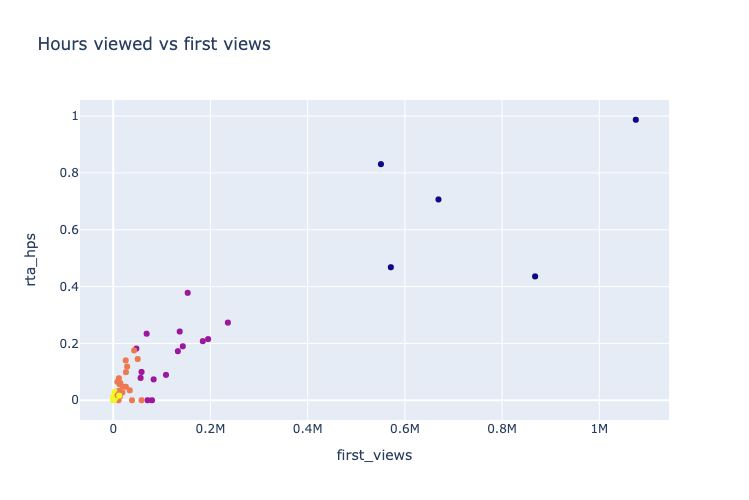

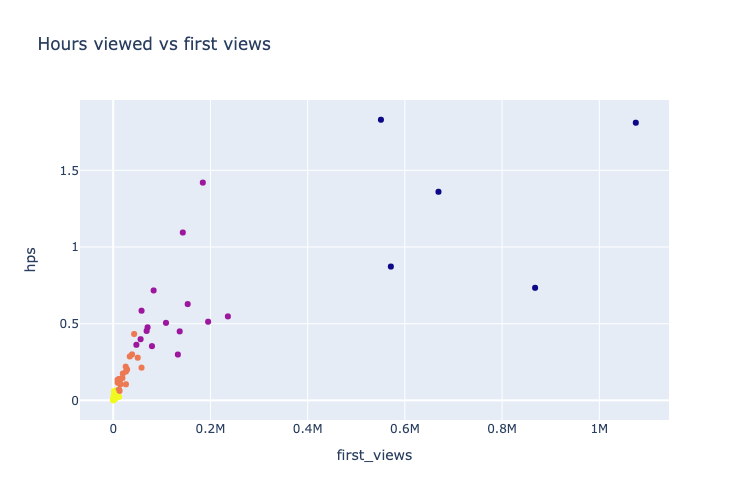

In [95]:
def get_pred_actual_plot(df_plt, x, y):
    data = []
    data.append(go.Scatter(
                x=df_plt[x],
                y=df_plt[y],
                mode='markers',
                marker_color = df_plt['tier'],
                text= df_plt['effective_start_date'].astype(str) + " " + df_plt['title_name'].astype(str) + ", tier " + df_plt['tier'].astype(str)))

    py.offline.init_notebook_mode(connected=True) 
    fig = go.Figure(data=data)

    fig.update_layout(
        title='Hours viewed vs first views',
        xaxis_title= x,
        yaxis_title= y,
        width=550,
        height=500,)
#         shapes=[
#         dict(
#             type= 'line',
#             yref= 'y', y0=2, y1= 15,
#             xref= 'x', x0=2, x1= 15)])
    py.offline.iplot(fig)
    
    return 

date_eval_start = '2021-04-01'
date_eval_end = '2021-10-01'

date_filter = (df_raw['effective_start_date']>=date_eval_start) &(df_raw['effective_start_date']<=date_eval_end)
df = df_raw[date_filter]
display(df[['first_views','hps','rta_hps']].describe(percentiles=percents))


fv = 'fv_pct'
hv = 'hv_pct'

df['fv_pct'] = pd.qcut(df.first_views,100, labels=False)
df['hv_pct'] = pd.qcut(df.hps,100, labels=False)
df['hv_rta_pct'] = pd.qcut(df.rta_hps,100, labels=False, duplicates='drop')

df['tier'] = 3
df.loc[(df[fv]>=50) & (df[hv]>=50), 'tier'] = 2
df.loc[(df[fv]>=75) & (df[hv]>=75), 'tier'] = 1
df.loc[(df[fv]>=95) & (df[hv]>=90), 'tier'] = 0

# df.loc[t3, 'tier'] = 3
display(df.groupby(by='tier').count())
get_pred_actual_plot(df, 'first_views','rta_hps')
get_pred_actual_plot(df, 'first_views','hps')